In [284]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import torch.nn as nn
from torch.nn import ReLU as relu
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
from torch.utils.tensorboard import SummaryWriter

In [251]:
proteins = pd.read_csv('../data/train_proteins.csv')
proteins.head()

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [252]:
npx_features = pd.pivot(proteins, index='visit_id', values='NPX', columns='UniProt')

In [253]:
npx_features = npx_features.fillna(0)

<AxesSubplot: xlabel='UniProt', ylabel='UniProt'>

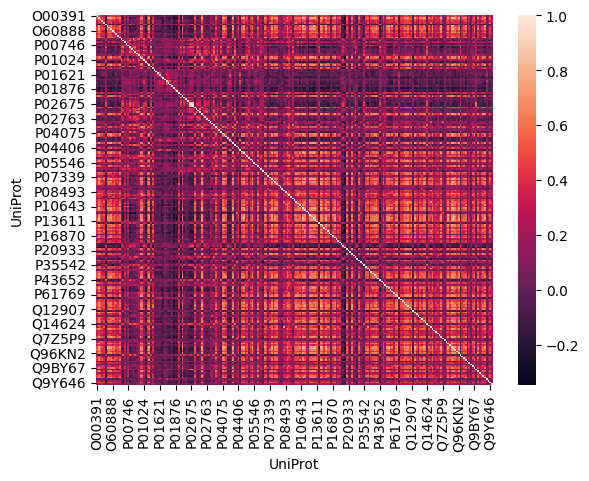

In [45]:
sns.heatmap(npx_features.corr())

In [255]:
clinical_data = pd.read_csv('../data/train_clinical_data.csv')
clinical_data.set_index('visit_id', inplace=True)
clinical_data.head()

,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
visit_id,,,,,,,
55_0,55,0,10.0,6.0,6,NaN,NaN
55_3,55,3,10.0,7.0,19,NaN,NaN
55_6,55,6,8.0,10.0,58,NaN,NaN
55_9,55,9,8.0,9.0,17,0.0,On
55_12,55,12,10.0,10.0,2,0.0,On


In [286]:
li = []
for idx, v in enumerate(clinical_data.index.values):
    parts = v.split('_')
    if parts[1] == '0':
        li.append('00000')
    else: 
        li.append(clinical_data.index.values[idx-1])
        
def offset_updrs2(row):
    if (row['offset']=='00000'):
        return 0
    else: 
        return clinical_data.loc[row['offset']]['updrs_2']

def offset_updrs1(row):
    if (row['offset']=='00000'):
        return 0
    else: 
        return clinical_data.loc[row['offset']]['updrs_1']

clinical_data['offset'] = li

clinical_data['offset_updrs2_offset'] = clinical_data.apply(offset_updrs2,axis=1)
clinical_data['offset_updrs1_offset'] = clinical_data.apply(offset_updrs1,axis=1)

def smape(a, b):
    return  100*pd.Series(abs((a-b)/((a+b)/2))).fillna(0).sum()/len(a)

clinical_data.fillna(0, inplace=True)

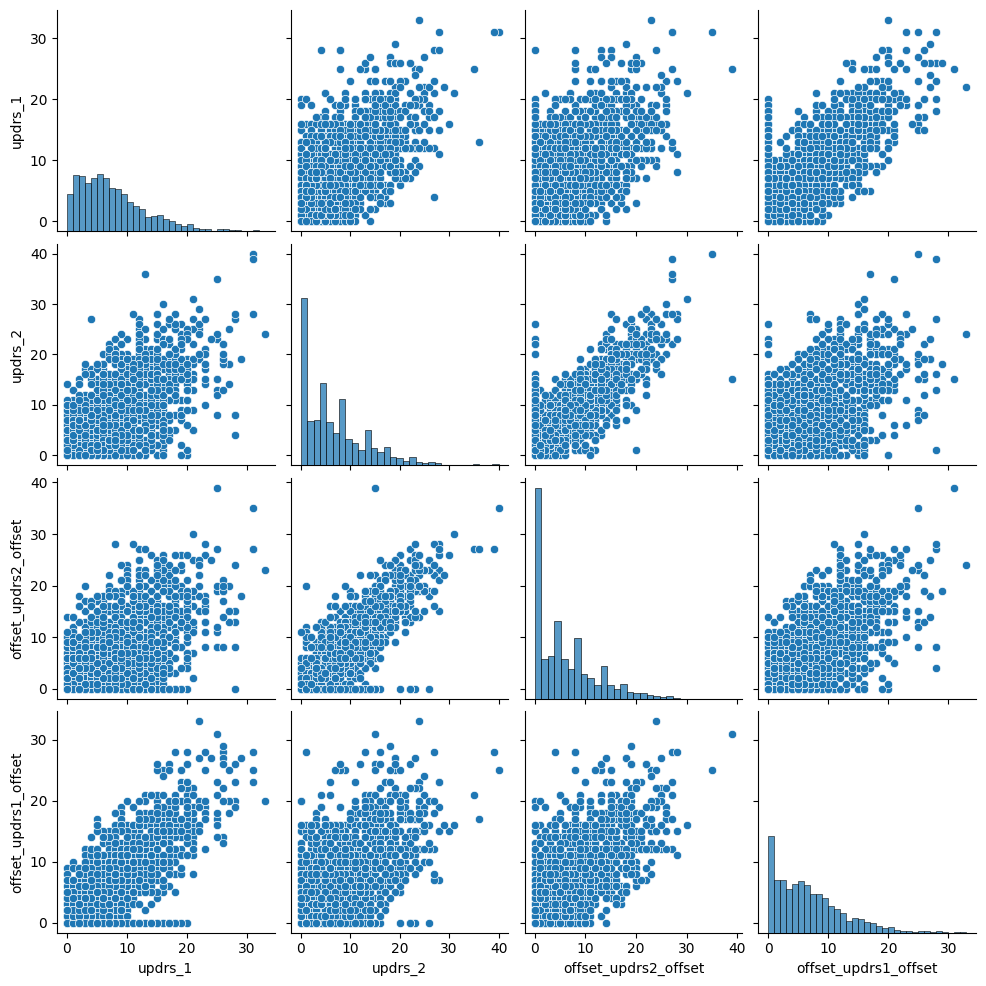

In [259]:
sns.pairplot(clinical_data[['updrs_1','updrs_2', 'offset_updrs2_offset', 'offset_updrs1_offset']])

In [260]:
dataset = pd.merge(clinical_data[['updrs_2', 'offset_updrs2_offset','offset_updrs1_offset']], npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
dataset.head()

,updrs_2,offset_updrs2_offset,offset_updrs1_offset,O00391,O00533,O00584,O14498,O14773,O14791,O15240,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
visit_id,,,,,,,,,,,,,,,,,,,,,
55_0,6.0,0.0,0.0,11254.3,732430.0,39585.8,41526.9,31238.00,4202.71,177775.0,...,365475.0,35528.0,97005.6,23122.5,60912.6,408698.0,0.0,29758.8,23833.7,18953.5
55_6,10.0,7.0,10.0,13163.6,630465.0,35220.8,41295.0,26219.90,4416.42,165638.0,...,405676.0,30332.6,109174.0,23499.8,51655.8,369870.0,0.0,22935.2,17722.5,16642.7
55_12,10.0,9.0,8.0,15257.6,815083.0,41650.9,39763.3,30703.60,4343.60,151073.0,...,303953.0,43026.2,114921.0,21860.1,61598.2,318553.0,65762.6,29193.4,28536.1,19290.9
55_36,18.0,13.0,14.0,13530.8,753832.0,43048.9,43503.6,33577.60,5367.06,101056.0,...,303597.0,48188.4,109794.0,23930.6,70223.5,377550.0,74976.1,31732.6,22186.5,21717.1
942_6,2.0,2.0,7.0,11218.7,399518.0,20581.0,31290.9,6173.58,2564.37,160526.0,...,253373.0,27431.8,93796.7,17450.9,21299.1,306621.0,82335.5,24018.7,18939.5,15251.2


In [263]:
Y = dataset[dataset.columns[0]].values
X = dataset[dataset.columns[3:]].values
X_noscale = dataset[dataset.columns[1:3]].values

In [264]:
X_noscale

array([[ 0.,  0.],
       [ 7., 10.],
       [ 9.,  8.],
       ...,
       [ 7.,  2.],
       [ 7.,  6.],
       [10.,  9.]])

In [266]:
X_scaled = StandardScaler().fit_transform(X)
final_X = np.hstack((X_noscale, X_scaled))

In [267]:
final_X, Y

(array([[ 0.        ,  0.        ,  0.55593005, ...,  1.53533647,
          0.68811783, -0.0491051 ],
        [ 7.        , 10.        ,  0.88188646, ...,  0.89127678,
         -0.14046241, -0.24859807],
        [ 9.        ,  8.        ,  1.23937493, ...,  1.48197001,
          1.32568749, -0.01997712],
        ...,
        [ 7.        ,  2.        ,  1.04770716, ..., -1.27350982,
         -0.23358143,  1.51440424],
        [ 7.        ,  6.        ,  1.13726707, ..., -1.27350982,
          0.34273144,  1.73227702],
        [10.        ,  9.        ,  0.44245221, ..., -1.27350982,
          0.19528396,  1.72771012]]),
 array([ 6., 10., 10., ...,  7.,  8.,  6.]))

In [268]:
lm =LinearRegression(n_jobs=-1)
cvr = cross_validate(lm, final_X, Y, cv=5, scoring=('r2'))

In [269]:
cvr

{'fit_time': array([0.04027748, 0.04309225, 0.04059863, 0.041924  , 0.03974128]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_score': array([0.48835018, 0.33993179, 0.41319996, 0.58530805, 0.57284025])}

In [271]:
rf = RandomForestRegressor(n_jobs=-1)
cvr = cross_validate(rf, final_X, Y, cv=5, scoring=('r2'))

In [272]:
cvr

{'fit_time': array([2.93548536, 1.67749596, 1.53495812, 1.32963753, 1.3874166 ]),
 'score_time': array([0.03034711, 0.02434564, 0.02074504, 0.01257133, 0.01972485]),
 'test_score': array([0.73232619, 0.63642064, 0.61120077, 0.74334874, 0.71577628])}

In [273]:
X_train, X_test, Y_train, Y_test = train_test_split(final_X, Y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, Y_train)

RandomForestRegressor(n_jobs=-1)

88.50317281983968

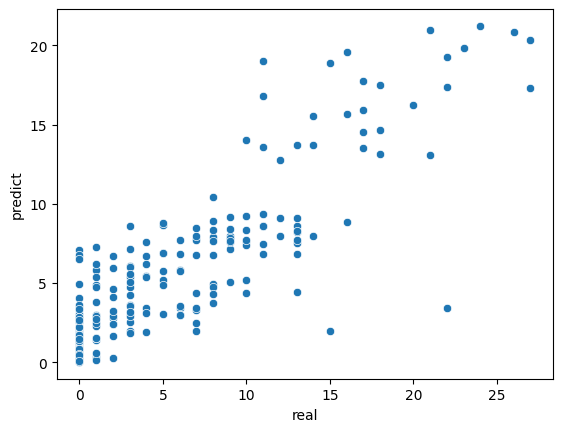

In [274]:
Y_predict = model.predict(X_test)
#Y_test
z = pd.DataFrame({'predict': Y_predict, 'real': Y_test})

sns.scatterplot(data=z, x='real', y='predict')

smape(Y_predict, Y_test)

In [277]:
gb = HistGradientBoostingRegressor()

cvr = cross_validate(gb, final_X, Y, cv=5, scoring=('r2'))


In [278]:
cvr

{'fit_time': array([3.07840681, 3.0638361 , 3.04562473, 3.03997922, 3.1700604 ]),
 'score_time': array([0.        , 0.00400352, 0.        , 0.00399947, 0.00399661]),
 'test_score': array([0.70631642, 0.59982999, 0.59657746, 0.70823011, 0.68557395])}

In [294]:
class BrownMunde(nn.Module):
    def __init__(self, protein_size):
        super().__init__()
        self.layer1 = nn.Linear(protein_size, 100)
        self.layer2 = nn.Linear(100, 50)
        self.layer3 = nn.Linear(50, 25)
        self.layer4 = nn.Linear(25,1)
        self.relu = relu()

    def forward(self, x):
        x =  self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        return self.layer4(x)

In [295]:
#updrs 2
model = BrownMunde(229)
loss_f = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=4e-4)

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

train_list = []

model.to(device)

writer = SummaryWriter()

for idx in range(len(X_train)):
    train_list.append((X_train[idx], Y_train[idx]))
    

d = DataLoader(train_list, batch_size=1, shuffle=True)
l = 0
for epoch in range(30):
    for step, data in tqdm(enumerate(d)):
        optimizer.zero_grad()
        x, y = data
        x=x.to(device)
        y=y.to(device)
        output = model(x.float())
        loss = loss_f(output, y.float())
        l+=loss
        loss.backward()
        optimizer.step()
        
        if (step/50 > 0) & (step % 50 == 0) :
            writer.add_scalar("BM Loss/Step", l, (epoch*len(d)+step))
            l=0


0it [00:00, ?it/s]c:\Users\prith\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
854it [00:01, 568.27it/s]
854it [00:01, 590.77it/s]
854it [00:01, 621.71it/s]
854it [00:01, 580.71it/s]
854it [00:01, 576.76it/s]
854it [00:02, 404.75it/s]
854it [00:01, 633.78it/s]
854it [00:01, 611.11it/s]
854it [00:01, 701.09it/s]
854it [00:01, 689.46it/s]
854it [00:01, 692.13it/s]
854it [00:01, 699.26it/s]
854it [00:01, 733.27it/s]
854it [00:01, 683.23it/s]
854it [00:01, 711.13it/s]
854it [00:01, 672.94it/s]
854it [00:01, 681.17it/s]
854it [00:01, 728.82it/s]
854it [00:01, 693.31it/s]
854it [00:01, 693.42it/s]
854it [00:01, 674.53it/s]
854it [00:01, 687.98it/s]
854it [00:01, 739.04it/s]
854it [0

In [296]:
d_test = DataLoader(X_test, batch_size=1) #, shuffle=True)
output_list = []
with torch.no_grad():
    for step, data in tqdm(enumerate(d_test)):
        output = model(data.to(device).float())
        output_list.append(torch.round(output.detach()).cpu().numpy()[0][0])
output_list = np.array(output_list)

214it [00:00, 2157.94it/s]


In [297]:
r2_score(Y_test, output_list), smape(output_list, Y_test)

C:\Users\prith\AppData\Local\Temp\ipykernel_17820\241722176.py:27: RuntimeWarning: invalid value encountered in divide
  return  100*pd.Series(abs((a-b)/((a+b)/2))).fillna(0).sum()/len(a)


(0.6431845192939868, 69.52910361155745)

<AxesSubplot: >

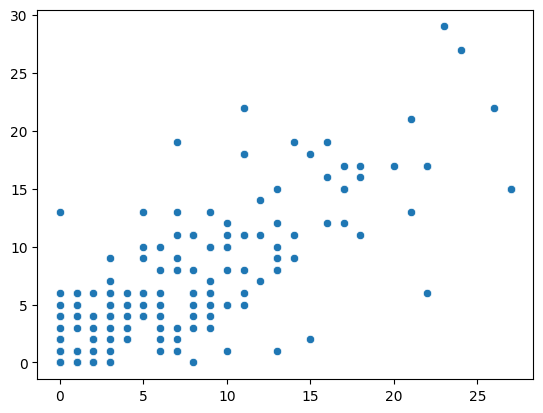

In [298]:
sns.scatterplot(x=Y_test,y=output_list)